## Libraries

In [57]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model
import matplotlib.pyplot as plt

import os
import json
import collections

## Download Coco Dataset
Training and validation Images/Annotations from 2014

In [2]:
# Download train image files
train_image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + train_image_folder):
    train_image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
    train_image_folder = os.path.dirname(train_image_zip) + train_image_folder
    os.remove(train_image_zip)
else:
    train_image_folder = os.path.abspath('.') + train_image_folder


# Download validation image files
val_image_folder = '/val2014/'
if not os.path.exists(os.path.abspath('.') + val_image_folder):
    val_image_zip = tf.keras.utils.get_file('val2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/val2014.zip',
                                      extract = True)
    val_image_folder = os.path.dirname(val_image_zip) + val_image_folder
    os.remove(val_image_zip)
else:
    val_image_folder = os.path.abspath('.') + val_image_folder


# Download caption annotation files for training and validation
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
    train_annotations_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
    val_annotations_file = os.path.dirname(annotation_zip)+'/annotations/captions_val2014.json'
    os.remove(annotation_zip)
else:
    train_annotations_file = os.path.abspath('.')+'/annotations/captions_train2014.json'
    val_annotations_file = os.path.abspath('.')+'/annotations/captions_val2014.json'


252878848/252872794 [==============================] - 5s 0us/step


In [3]:
with open(train_annotations_file, 'r') as file:
    train_annotations = json.load(file)

with open(val_annotations_file, 'r') as file:
    val_annotations = json.load(file)

In [4]:
for anot in train_annotations['annotations']:
    print(anot)
    break

{'image_id': 318556, 'id': 48, 'caption': 'A very clean and well decorated empty bathroom'}


In [5]:
# Group all train captions together having the same image ID.
train_image_id_to_captions = {}
train_image_ids = []
for anot in train_annotations['annotations']:
    caption = f"<start> {anot['caption']} <end>"
    train_image_id = 'COCO_train2014_' + '%012d' % (anot['image_id'])
    try:
        train_image_id_to_captions[train_image_id].append(caption)
    except:
        train_image_ids.append(train_image_id)
        train_image_id_to_captions[train_image_id] = [caption]

# Group all validation captions together having the same image ID.
val_image_id_to_captions = {}
val_image_ids = []
for anot in val_annotations['annotations']:
    caption = f"<start> {anot['caption']} <end>"
    val_image_id = 'COCO_val2014_' + '%012d' % (anot['image_id'])
    try:
        val_image_id_to_captions[val_image_id].append(caption)
    except:
        val_image_ids.append(val_image_id)
        val_image_id_to_captions[val_image_id] = [caption]

In [6]:
print(f"Train Images: {len(train_image_ids)}")
print(f"Validation Images: {len(val_image_ids)}")

Train Images: 82783
Validation Images: 40504


## Input Pipeline

### Preprocess Images

In [7]:
image_dim = (64, 64)
num_patches_h = 4
num_patches_v = 4

patch_height = image_dim[0]//num_patches_v
patch_width = image_dim[1]//num_patches_h

In [8]:
# Loading, resizing and normalizing image
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_dim, method='nearest')
    img = 2*(img/255)-1
    return img

# Divide image in equal patches
def create_patches(image, batch = True):
    if not batch:
        image = tf.expand_dims(image, 0)
    patches = tf.image.extract_patches(images=image,
                           sizes=[1, patch_height, patch_width, 1],
                           strides=[1, patch_height, patch_width, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')
    if not batch:
        patches = tf.squeeze(patches)
    return patches

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(48, 48, 3)


['<start> An empty kitchen with white and black appliances. <end>',
 '<start> A refrigerator and stove are in a small kitchen area.  <end>',
 '<start> Small kitchen in a personal home with dual sinks. <end>',
 '<start> A small kitchen with sink, stove and refrigerator. <end>',
 '<start> A small kitchen with several appliances and cookware. <end>']

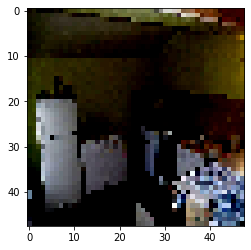

In [9]:
img = load_image(train_image_folder + train_image_ids[5] + '.jpg')
captions = train_image_id_to_captions[train_image_ids[5]]
print(img.shape)
plt.imshow(img)
captions

### Preprocess Captions

In [10]:
train_captions = []
val_captions = []

train_image_path = []
val_image_path = []

for img_id in train_image_ids:
    caption_list = train_image_id_to_captions[img_id]
    train_captions.extend(caption_list)
    train_image_path.extend([train_image_folder + img_id + '.jpg'] * len(caption_list))

for img_id in val_image_ids:
    caption_list = val_image_id_to_captions[img_id]
    val_captions.extend(caption_list)
    val_image_path.extend([val_image_folder + img_id + '.jpg'] * len(caption_list))

all_captions = train_captions + val_captions

# Choose the top 5000 words from the vocabulary
WORD_NUM = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=WORD_NUM,
                                                  oov_token='<unk>',
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(all_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors for train captions
train_captions_tokenized = tokenizer.texts_to_sequences(train_captions)
val_captions_tokenized = tokenizer.texts_to_sequences(val_captions)
    
max_seq_len = max(len(seq) for seq in train_captions_tokenized + val_captions_tokenized)

# Pad sequences
train_captions_padded = tf.keras.preprocessing.sequence.pad_sequences(train_captions_tokenized, maxlen=max_seq_len, padding='post')
val_captions_padded = tf.keras.preprocessing.sequence.pad_sequences(val_captions_tokenized, maxlen=max_seq_len, padding='post')

### Build Dataset

In [11]:
BATCH_SIZE = 4

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_path, train_captions_padded))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_path, val_captions_padded))

# Shuffle dataset
train_dataset = train_dataset.shuffle(BATCH_SIZE)
val_dataset = val_dataset.shuffle(BATCH_SIZE)

# Map paths to images and create batches
train_dataset = train_dataset.map(lambda img_path, cap: (load_image(img_path), cap),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)
val_dataset = val_dataset.map(lambda img_path, cap: (load_image(img_path), cap),
                              num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

# # Map images to patches
train_dataset = train_dataset.map(lambda img, cap: (create_patches(img), cap),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(lambda img, cap: (create_patches(img), cap),
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Prefetch
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
for elem in train_dataset.take(1):
    print(elem[0])
    print(elem[1])

tf.Tensor(
[[[[-0.6156863  -0.2862745  -0.09019607 ...  0.30980396  0.4901961
     0.6       ]
   [-0.78039217 -0.4980392  -0.32549018 ... -0.81960785 -0.4588235
    -0.3333333 ]
   [-0.8666667  -0.6862745  -0.5764706  ... -0.8117647  -0.6627451
    -0.54509807]
   [-0.94509804 -0.8039216  -0.7254902  ... -0.85882354 -0.60784316
    -0.52156866]]

  [[ 0.99215686  0.99215686  0.99215686 ...  0.4039216   0.38823533
     0.41176474]
   [ 0.3411765   0.47450984  0.5294118  ... -0.75686276 -0.372549
    -0.23921567]
   [-0.9137255  -0.5921569  -0.5764706  ...  0.6313726   0.78039217
    -0.04313725]
   [-0.38039213  0.30980396  0.38823533 ... -0.75686276 -0.44313723
    -0.36470586]]

  [[ 0.96862745  0.9843137   0.9764706  ...  0.35686278  0.32549024
     0.2313726 ]
   [ 0.27058828  0.27058828  0.254902   ...  0.2313726   0.20784318
     0.07450986]
   [-0.69411767 -0.36470586 -0.23921567 ... -0.00392157  0.0196079
     0.05882359]
   [ 0.92941177  0.94509804  0.8352941  ...  0.75686276 

## Build Model

### Scaled Dot Product Attention

In [14]:
def scaled_dot_product_attention(query, key, value, mask):
    # Calculate the attention scores from query and key
    scores = tf.matmul(query, key, transpose_b=True) / tf.math.sqrt(tf.cast(key.shape[-1],tf.float32))

    # Add a negative mask so that the softmax-scores for values that the model shouldn't attend to will be near 0
    if mask is not None:
        scores += (mask * -1e9)  

    # Calculate the softmax score
    attention_weights = tf.nn.softmax(scores)

    # Weight values by softmax score
    output = attention_weights @ value

    return output, attention_weights

###  Multi Head Attention

In [15]:
class MultiHeadAttention(Layer):
    def __init__(self, model_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.model_dim = model_dim
        
        # Make sure model dimension can be divided by the number of attention heads
        assert model_dim % num_heads == 0

        self.head_dim = model_dim // num_heads

        # Create Query, Key and Value matrix
        self.wq = tf.keras.layers.Dense(model_dim)
        self.wk = tf.keras.layers.Dense(model_dim)
        self.wv = tf.keras.layers.Dense(model_dim)

        # Create output matrix
        self.wo = tf.keras.layers.Dense(model_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
        # Transpose so that output has shape (batch_size, num_head, seq_len, head_dim)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, value, key, query, mask):
        batch_size = query.shape[0]

        # shape == (batch_size, seq_len, model_dim)
        query = self.wq(query)
        key = self.wk(key)
        value = self.wv(value)

        # Split up the heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # attention.shape == (batch_size, num_heads, seq_len, head_dim)
        attention, attention_weights = scaled_dot_product_attention(query, key, value, mask)

        # Concatenate heads back together
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, head_dim)
        attention = tf.reshape(attention,(batch_size, -1, self.model_dim))  # (batch_size, seq_len, model_dim)

        output = self.wo(attention)  # (batch_size, seq_len, output_dim)

        return output, attention_weights

### Positional Encodings

In [16]:
def positional_encoding(seq_len, model_dim):
    # Calculate the positional encoding following the formulation of the 'Attention is all you need' paper
    pos = np.expand_dims(np.arange(seq_len),1)
    i = np.expand_dims(np.arange(model_dim),0)
    angle_rads = pos/(10000**(2*(i//2)/model_dim))

    # Apply sin to even indices in the array
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # Apply cos to odd indices in the array
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    # Add batch dimension
    pos_encoding = np.expand_dims(angle_rads,0)

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 10, 65)


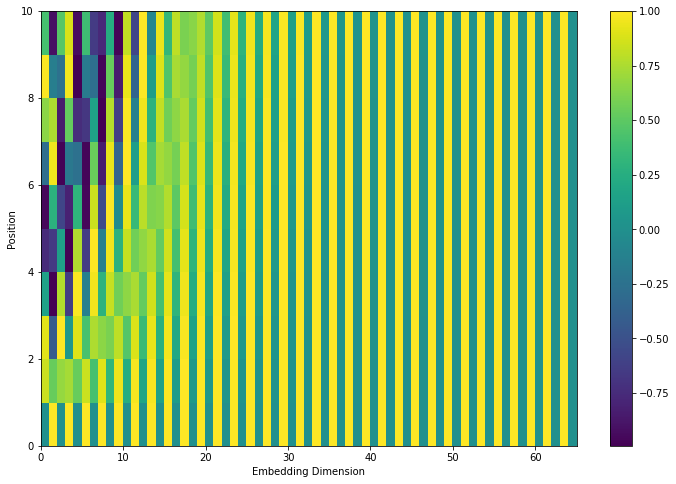

In [17]:
n, d = 10, 65
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

plt.figure(figsize=(12,8))
plt.pcolormesh(pos_encoding)
plt.ylabel('Position')
plt.xlabel('Embedding Dimension')
plt.colorbar()
plt.show()

### Look Ahead Mask

In [18]:
def look_ahead_mask(size):
    # Create a triangular matrix filled with ones to prevent the decoder from attending to it's future prediction targets
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

### Encoder Layer

In [19]:
class EncoderLayer(Layer):
    def __init__(self, model_dim, num_heads, ffn_units, dropout_rate):
        super(EncoderLayer, self).__init__()

        self.attention = MultiHeadAttention(model_dim, num_heads)
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm_1 = tf.keras.layers.LayerNormalization()

        self.feedForward = [
            tf.keras.layers.Dense(ffn_units, activation='relu'),
            tf.keras.layers.Dense(model_dim)
        ]
        self.dropout_2 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
    
    def call(self, x, mask, training = False):
        # Self-Attention block with residual connection
        attention_out, _ = self.attention(x, x, x, mask)
        attention_out = self.dropout_1(attention_out,training=training)
        x = self.layernorm_1(x + attention_out)

        # Feed-Forward block with residual connection
        feedForward_out = x
        for layer in self.feedForward:
            feedForward_out = layer(feedForward_out)
        feedForward_out = self.dropout_2(feedForward_out, training=training)
        x = self.layernorm_2(x + feedForward_out)

        return x

### Decoder Layer

In [20]:
class DecoderLayer(Layer):
    def __init__(self, model_dim, num_heads, ffn_units, dropout_rate):
        super(DecoderLayer, self).__init__()

        self.attention = MultiHeadAttention(model_dim, num_heads)
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm_1 = tf.keras.layers.LayerNormalization()

        self.enc_dec_attention = MultiHeadAttention(model_dim, num_heads)
        self.dropout_2 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm_2 = tf.keras.layers.LayerNormalization()

        self.feedForward = [
            tf.keras.layers.Dense(ffn_units, activation='relu'),
            tf.keras.layers.Dense(model_dim)
        ]
        self.dropout_3 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm_3 = tf.keras.layers.LayerNormalization()
    
    def call(self, x, enc_out, mask, training = False):
        # Self-Attention block with residual connection
        attention_out, _ = self.attention(x, x, x, mask)
        attention_out = self.dropout_1(attention_out,training=training)
        x = self.layernorm_1(x + attention_out)

        # Encoder-Decoder Attention block with residual connection
        enc_dec_attention_out, attention_weights = self.enc_dec_attention(enc_out, enc_out, x, mask=None)
        enc_dec_attention_out = self.dropout_2(enc_dec_attention_out,training=training)
        x = self.layernorm_2(x + enc_dec_attention_out)

        # Feed-Forward block with residual connection
        feedForward_out = x
        for layer in self.feedForward:
            feedForward_out = layer(feedForward_out)
        feedForward_out = self.dropout_3(feedForward_out, training=training)
        x = self.layernorm_3(x + feedForward_out)

        return x, attention_weights

### Encoder

In [21]:
class Encoder(Layer):
    def __init__(self, num_layers, model_dim, num_heads, ffn_units, seq_len, dropout_rate):
        super(Encoder, self).__init__()
        self.model_dim = model_dim

        self.embedding = tf.keras.layers.Dense(model_dim)
        self.pos_encoding = positional_encoding(seq_len,model_dim)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        self.enc_layers = [EncoderLayer(model_dim,num_heads,ffn_units,dropout_rate) for _ in range(num_layers)]

    def call(self, x, mask, training=False):
        batch_size = x.shape[0]

        # Reshape the input so that the image patches are in one sequence
        # (batch_size, horizontal_patches, vertical_patches, pixels) -> (batch_size, patches, pixels)
        x = tf.reshape(x,(batch_size,-1, x.shape[-1]))

        seq_len = x.shape[1]

        # Embed input in model_dim and add positional encoding 
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.model_dim, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        # Go through the encoder layers
        for layer in self.enc_layers:
            x = layer(x, mask, training)

        return x

### Decoder

In [50]:
class Decoder(Layer):
    def __init__(self, vocab_size, num_layers, model_dim, num_heads, ffn_units, seq_len, dropout_rate):
        super(Decoder, self).__init__()
        self.model_dim = model_dim

        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=model_dim)
        self.pos_encoding = positional_encoding(seq_len, model_dim)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        self.dec_layers = [DecoderLayer(model_dim,num_heads,ffn_units,dropout_rate) for _ in range(num_layers)]

    def call(self, x, enc_out, mask, training=False):
        seq_len = x.shape[1]
        attention_weights = {}
        
        # Embed input in model_dim and add positional encoding 
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.model_dim, tf.float32))
        x += self.pos_encoding[:, :seq_len]

        x = self.dropout(x, training=training)

        # Go through the decoder layers
        for i, layer in enumerate(self.dec_layers):
            x, enc_dec_attention = layer(x, enc_out, mask, training)
            
            attention_weights[f'dec_layer_{i}'] = enc_dec_attention

        return x, attention_weights

### Transformer

In [23]:
class Transformer(Model):
    def __init__(self, vocab_size, num_enc_layers, num_dec_layers, model_dim, num_heads, ffn_units, enc_seq_len, dec_seq_len, dropout_rate):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_enc_layers, model_dim, num_heads, ffn_units, enc_seq_len, dropout_rate)
        self.decoder = Decoder(vocab_size, num_dec_layers, model_dim, num_heads, ffn_units, dec_seq_len, dropout_rate)

        # Output logit scores for the vocabulary
        self.output_layer = tf.keras.layers.Dense(vocab_size)
    
    def call(self, input, mask=None, training=False):
        x, target = input
        encoder_out = self.encoder(x, mask=None, training=training)
        decoder_out, attention_weights = self.decoder(target, encoder_out, mask, training=training)
        output = self.output_layer(decoder_out)

        return output, attention_weights

## Training

### Define Training Function

In [24]:
from IPython.display import clear_output

def visualize_progress(num_epochs, epoch, train_losses, test_losses):
    clear_output(wait=True)
    fig = plt.figure(figsize=(15,5))
    plt.xlim((0,num_epochs))
    plt.plot(train_losses,label='Training')
    plt.plot(test_losses,label='Test')
    plt.ylabel('Loss',fontsize=24)
    plt.xlabel('Epochs',fontsize=24)
    plt.title(f'Epoch: {epoch+1}', fontweight='bold', fontsize=30)
    plt.xticks(np.arange(0,num_epochs,2))
    plt.legend()
    plt.show()

In [25]:
def train_model(model, train_dataset, val_dataset, optimizer, num_epochs, dec_seq_len):
    running_average_factor = 0.95

    # create mask
    mask = look_ahead_mask(size = dec_seq_len)

    # Initialize lists for later visualization.
    train_losses = []
    test_losses = []
    
    # Train loop for num_epochs epochs.
    for epoch in range(num_epochs):
            
        # Training
        running_average_loss = 0
        for input_seq, target_seq in train_dataset:
            train_loss = train_step(model, input_seq, target_seq, mask, optimizer)
            running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss

        train_losses.append(running_average_loss.numpy())

        # Test
        total_test_loss = 0
        for input_seq, target_seq in val_dataset:
            test_loss = test_step(model, input_seq, target_seq)
            total_test_loss += test_loss

        test_losses.append(total_test_loss)

        visualize_progress(num_epochs, epoch, train_losses, test_losses)

        # Display loss and accuracy for current epoch    
        print(f'Epoch: __ {epoch+1}')
        print('Train loss: ',running_average_loss.numpy())
        print('Test loss: ',total_test_loss.numpy())

### Define Training Step

In [120]:
@tf.function
def train_step(model, input_seq, target_seq, look_ahead_mask, optimizer):
    # target_seq_prior is the input for the decoder utilizing teacher-forcing, it does not contain the <end> token
    target_seq_prior = target_seq[:, :-1]
    # target_seq_posterior is the target output, it does not contain the <start> token
    target_seq_posterior = target_seq[:, 1:]

    with tf.GradientTape() as tape:
        pred, _ = model((input_seq, target_seq_prior), look_ahead_mask, training=True)
        loss = loss_function(target_seq_posterior, pred)
        gradients = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function
def test_step(model, input_seq, target_seq):
    batch_size = target_seq.shape[0]
    output = tf.expand_dims(tf.repeat([tokenizer.word_index['<start>']],batch_size), 1)
    for i in range(dec_seq_len):
        mask = look_ahead_mask(output.shape[1])
        pred, _ = model((input_seq, output), mask)

        # Take the last prediction
        pred = pred[:, -1:, :]

        # Get the predicted word
        predicted_id = tf.argmax(pred, axis=-1, output_type=tf.int32)

        try:
            softmax_pred = tf.concat([softmax_pred,pred], axis=1)
        except:
            softmax_pred = pred
                
        # Add latest prediction to the output sequence
        output = tf.concat([output, predicted_id], axis=-1)
    
    loss = loss_function(target_seq[:, 1:], softmax_pred)

    return loss

In [115]:
# Initialize the loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(target, pred):
    # Create mask to ignore padding
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss = loss_object(target, pred)

    mask = tf.cast(mask, dtype=loss.dtype)

    # Set loss for padded values to 0
    loss *= mask

    # Calculate mean loss
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)

    return loss

In [28]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, model_dim, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.model_dim = model_dim
    self.model_dim = tf.cast(self.model_dim, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.model_dim) * tf.math.minimum(arg1, arg2)

### Train Transformer

In [ ]:
tf.keras.backend.clear_session()

num_enc_layers = 6
num_dec_layers = 2
model_dim = 32
num_heads = 4
ffn_units = 64
enc_seq_len = num_patches_h*num_patches_v
dec_seq_len = max_seq_len -1
dropout_rate = 0.3
epochs = 2

learning_rate = CustomSchedule(model_dim)

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

# Initialize model
captioning_model = Transformer(WORD_NUM, num_enc_layers, num_dec_layers, model_dim, num_heads, ffn_units, enc_seq_len, dec_seq_len, dropout_rate)

train_model(
    model = captioning_model,
    train_dataset = train_dataset,
    val_dataset = val_dataset,
    optimizer = optimizer,
    num_epochs = epochs,
    dec_seq_len = dec_seq_len
)

## Evaluation

### Generate Caption

In [112]:
def greedy_evaluate(image_id):
    img = load_image(val_image_folder + image_id + '.jpg')
    batched_img = tf.expand_dims(img, 0)
    patches = create_patches(batched_img)

    output = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    for i in range(dec_seq_len):
        mask = look_ahead_mask(output.shape[1])
        
        predictions, attention_weights = captioning_model((patches, output), mask)

        predictions = predictions[:, -1:, :]

        predicted_id = tf.argmax(predictions, axis=-1, output_type=tf.int32)
        
        output = tf.concat([output, predicted_id], axis=-1)
        
        predicted_id = tf.squeeze(predicted_id)

        if tokenizer.index_word[predicted_id.numpy()] == '<end>':
            break

    result = tokenizer.sequences_to_texts(output.numpy())[0]
        
    return img, result, attention_weights

In [ ]:
img_id = 8
img = load_image(val_image_folder + val_image_ids[img_id] + '.jpg')
captions = val_image_id_to_captions[val_image_ids[img_id]]
plt.imshow(img+1)
print('Goal: ',captions)
img, caption, attention_weights = greedy_evaluate(val_image_ids[img_id])
caption

In [68]:
def evaluate_beam_search(image_id):

    image = load_image(val_image_folder + image_id + '.jpg')
    image = tf.expand_dims(image, 0)
    image_patched = create_patches(image)
    

    best_predictions = {}
    # initialize predictions {score: [sequence]} with start token
    best_predictions[0] = [tokenizer.word_index['<start>']]
    
    beams = 5
 
    for i in range(dec_seq_len):
        for score, sequence in best_predictions.copy().items():
           
            mask = look_ahead_mask(len(sequence))
            predictions, _ = captioning_model((image_patched, tf.expand_dims(sequence, 0)), mask)

            # get k best new predictions and their score
            k_best = tf.math.top_k(tf.squeeze(predictions[:,-1,:]), k=beams)
            k_best = dict(zip(k_best[0].numpy(), k_best[1].numpy()))
            for new_score, new_element in k_best.items():
                if tokenizer.index_word[new_element] == '<end>':
                    return [tokenizer.index_word[elem] for elem in sequence]
                best_predictions[score + new_score] = sequence + [new_element]
                                            
        # trim dict to k best predictions
        best_predictions = collections.OrderedDict(sorted(best_predictions.items(), reverse=True)[:beams])

    return [tokenizer.index_word[elem] for elem in collections.OrderedDict(sorted(best_predictions.items(), reverse=True)[:1]).values()]

In [ ]:
img = load_image(val_image_folder + val_image_ids[img_id] + '.jpg')
captions = val_image_id_to_captions[val_image_ids[img_id]]
plt.imshow(img+1)
print('Goal: ',captions)
caption = evaluate_beam_search(val_image_ids[img_id])
caption

### Visualize Attention

In [96]:
def attention_plot(image, caption, attention_heads):
    fig = plt.figure(figsize=(5, 10))
    num_heads = attention_heads.shape[0]
    word_list = caption.split()[1:]
    
    for i in range(len(word_list)):
        for j, head in enumerate(attention_heads):
            att = np.reshape(head[i],(num_patches_h,num_patches_v))
            ax = fig.add_subplot(len(word_list),num_heads, j+1+i*num_heads)
            ax.set_title(word_list[i])
            img = ax.imshow((image+1)/2)
            ax.imshow(att, cmap='gray', alpha=0.6, extent=img.get_extent())
            ax.axis('off')

    plt.tight_layout()
    plt.show()

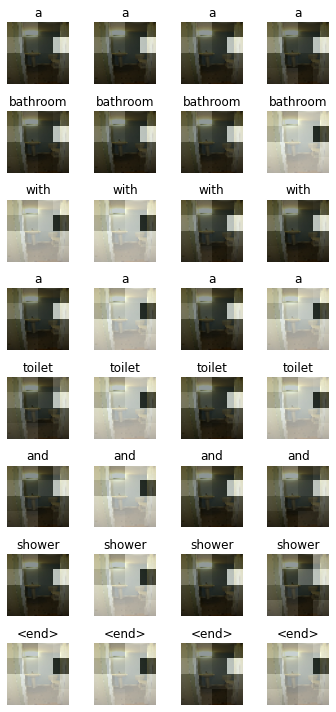

In [128]:
attention_plot(img, caption, attention_weights[f'dec_layer_{num_dec_layers-1}'][0])